# Pytorch CNN - Brain Tumor Detection
# https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from glob import glob

import sklearn
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Use Cuda")
else:
    device = torch.device('cpu')
    print("Use CPU")

Use CPU


# Upload data zip file

* kaggle에서 바로 불러오기\
{"username": "계정이름", "key":"캐글 API key"}\
참고 : https://teddylee777.github.io/kaggle/Kaggle-API-%EC%82%AC%EC%9A%A9%EB%B2%95

In [7]:
import os
os.getcwd()

'/Users/mireulee/kaggle'

In [ ]:
# 1. 캐글 accout에 들어가서 create new api token을 클릭 -> kaggle.json 파일을 다운받는다. 

# 2. 
! pip install -q kaggle
from google.colab import files
files.upload() #  kaggle.json 파일 업로드

# 3. 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# 4. 
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d archive

In [5]:
file_dir = 'brain_MRI'

# 1. Load data and preprocessing

* 이미지 파일 형식 및 차원 확인

In [6]:
path = glob(file_dir+'/yes/*')
for image in path[:5]:
    img = Image.open(image).convert("RGB")
    print(img, np.asarray(img).shape)

<PIL.Image.Image image mode=RGB size=232x309 at 0x1076F7E80> (309, 232, 3)
<PIL.Image.Image image mode=RGB size=911x938 at 0x1076F0700> (938, 911, 3)
<PIL.Image.Image image mode=RGB size=256x256 at 0x1076F0400> (256, 256, 3)
<PIL.Image.Image image mode=RGB size=467x586 at 0x10770CFD0> (586, 467, 3)
<PIL.Image.Image image mode=RGB size=512x512 at 0x1076F7E80> (512, 512, 3)


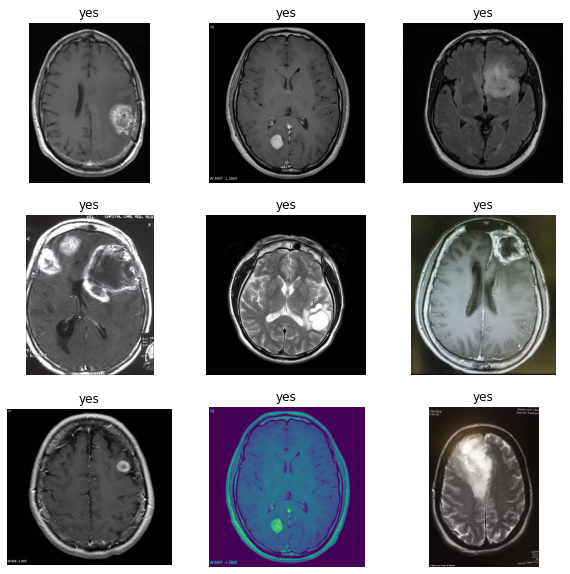

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    img = path[i]
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(img))
    plt.title(os.path.split(os.path.split(img)[0])[-1])
    plt.axis("off")

* 데이터 로드 클래스 (변경하지 마세요!)

In [6]:
# Do not change this class !!
class BrainMRIDataset(Dataset):

    def __init__(self, file_dir, transform):
        self.dataDirectory = file_dir
        self.transform = transform

        self.no_class = glob(file_dir+'/no/*')
        self.yes_class = glob(file_dir+'/yes/*')
        self.file_list = self.no_class + self.yes_class
        self.label_list = [0]*len(self.no_class) + [1]*len(self.yes_class)
        self.dataframe = pd.DataFrame({'image': self.file_list,
                                     'label': self.label_list})  
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self, index):
        img_path = self.dataframe['image'][index]
        labels = self.dataframe['label'][index]
        labels = labels.tolist()
      
        if type(img_path) == str:
            img_path = [img_path]

        img_array = []
        for image in img_path:
            img = Image.open(image).convert("RGB")
            img_transformed = self.transform(img)
            array = np.asarray(img_transformed)
            img_array.append(array)
            
        return [torch.tensor(img_array, device=device),torch.tensor(labels, device=device)]
    
    def __repr__(self):
        print("Data loading succeed!!")
        print("-"*100)
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(plt.imread(self.file_list[i]))
            plt.title(os.path.split(os.path.split(self.file_list[i])[0])[-1])
            plt.axis("off")

        rep = pd.DataFrame({'File Path' : self.file_list})
        return str(rep.head(9))

# customize your transformation

In [7]:
# you can add other 'torcivision.transforms.'
data_transform = transforms.Compose([
                                     transforms.Resize((227,227)), # do not change resize!!
                                     transforms.ToTensor(),        # do not change totensor!!
                                     ])

**alex net input data size에 맞춰 Resize 했습니다!**

In [8]:
# data_transform 을 정의하고, 밑의 코드의 결과값이 모두 (3,128,128)이 나오는지 확인하세요.
path = glob(file_dir+'/yes/*')
for image in path[:5]:
    img = Image.open(image).convert("RGB")
    print(np.asarray(data_transform(img)).shape)

(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)
(3, 227, 227)


Data loading succeed!!
----------------------------------------------------------------------------------------------------


              File Path
0  archive/no/30 no.jpg
1  archive/no/22 no.jpg
2  archive/no/41 no.jpg
3  archive/no/14 no.jpg
4  archive/no/no 10.jpg
5  archive/no/18 no.jpg
6   archive/no/no 9.png
7  archive/no/no 7.jpeg
8   archive/no/no 8.jpg

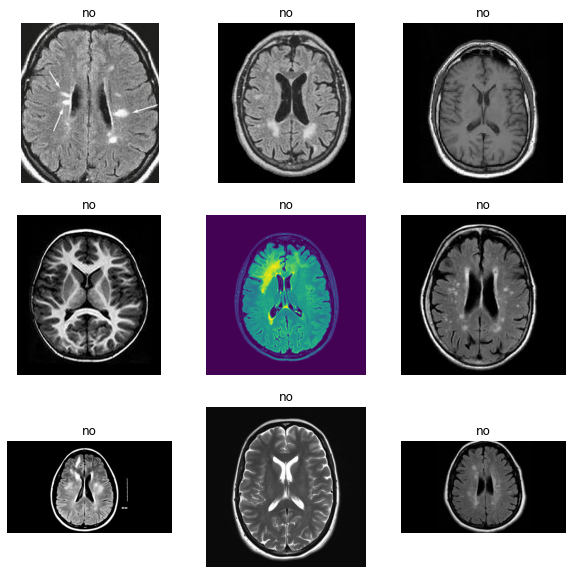

In [9]:
# load the data
dataset = BrainMRIDataset(file_dir, transform = data_transform)
dataset

# 2. Modeling

In [115]:
# can change, but remind the dimension
# First input must be : [1, 3, 128, 128]
# Last output must be : [1, 2]

class BrainTumorModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            # input : [1, 3, 128, 128]
            nn.Conv2d(3,256,kernel_size=3),     # output : 256 * 126 * 126
            nn.MaxPool2d(2,2),                  # output : 256 * 63 * 63
            nn.Conv2d(256,32,kernel_size=2)     # output : 32 * 62 * 62
        )
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,2)

    def forward(self,x):
        # input : [1, 3, 128, 128]
        x = F.relu(self.conv1(x))       # output : ??
        x = F.relu(self.linear1(x))     # output : ??
        x = self.linear2(x)             # output : ??
        x = self.flat(x)                # output : ??
        x = self.linear3(x)             # output : [1, 2]

        return x

In [71]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

![nn](alexnet_architecture.png)

In [10]:
class AlexNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # input : [1, 3, 224, 224]
            nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 11, stride=4, padding=0),     # 96 * 55 * 55
            nn.ReLU(), 
            nn.MaxPool2d(3, stride = 2),   # 96 * 27 * 27
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 2), #256 * 27 * 27
            nn.ReLU(), 
            nn.MaxPool2d(3, stride = 2), # 256 * 13 * 13
            nn.Conv2d(256, 384, kernel_size = 3, stride = 1, padding = 1), # 384 * 13 * 13
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size = 3, stride = 1, padding = 1), # 384 * 13 * 13
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1), # 256 * 13 * 13
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2) # 256 * 6 * 6
        )
        
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 6*6*256, out_features = 4096), 
            nn.ReLU(), 
            nn.Linear(in_features = 4096, out_features = 4096), 
            nn.ReLU(), 
            nn.Linear(in_features = 4096, out_features = 2)
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(-1, 256*6*6)
        x = self.classifier(x)
        return x

In [11]:
model = AlexNet()
model.to(device)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=2, bias=True)
  )
)

# 3. Training

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [13]:
# divide dataset to train and test.
train, test = random_split(dataset, [200, 53],generator=torch.Generator().manual_seed(42))
print("Total number of dataset:",len(dataset))
print("Train dataset:",len(train))
print("Test dataset:",len(test)) 

Total number of dataset: 253
Train dataset: 200
Test dataset: 53


In [14]:
epochs = 100
batch_size = 8
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(train)//batch_size):
    
        data, target = train[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target.long())

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

/var/folders/qd/t0nz5cxj0pg9qb3g0r2tfs240000gn/T/ipykernel_10119/2032097621.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return [torch.tensor(img_array, device=device),torch.tensor(labels, device=device)]


Epochs: 0 Loss: 1.1277509927749634
Epochs: 10 Loss: 0.6376183032989502
Epochs: 20 Loss: 0.5969471335411072
Epochs: 30 Loss: 0.6829587817192078
Epochs: 40 Loss: 0.2913241684436798
Epochs: 50 Loss: 0.30770421028137207
Epochs: 60 Loss: 0.14243046939373016
Epochs: 70 Loss: 0.030487289652228355
Epochs: 80 Loss: 7.978185863066756e-07
Epochs: 90 Loss: 2.4710956836315745e-07


# 4. Visualize the result

In [15]:
loss_list = [float(loss_list[i].detach().numpy()) for i in range(len(loss_list))]

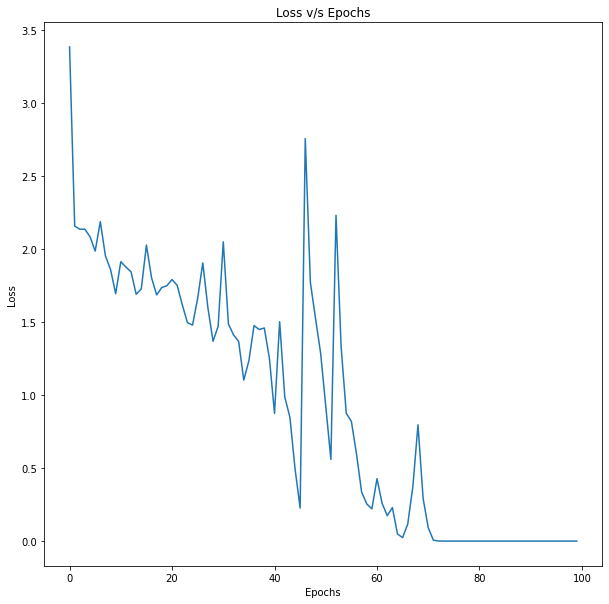

In [16]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)), loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 5. Testing

In [17]:
correct = 0
total = 0

with torch.no_grad():
    for data in test:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
    
        outputs = model(images.float())
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += 1
        
        correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (
    100 * correct / total))

# AlexNet(227*227) with lr = 0.001 :: 84% accuracy

Accuracy of test images: 84 %
